<a href="https://colab.research.google.com/github/andrewpark19/4thyear-FYP/blob/main/standard_cnn_binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Mon Jun  6 14:36:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.3 MB/s 


In [ ]:
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [ ]:
!unzip /content/drive/MyDrive/melanoma_data/isic_2020/train_2020/train_2020.zip > /dev/null
!unzip /content/drive/MyDrive/melanoma_data/isic_2020/test_2020/test_2020.zip > /dev/null
!unzip /content/drive/MyDrive/melanoma_data/isic_2019/train_2019/train_2019.zip > /dev/null


In [ ]:
train2020_dir = '/content/train_2020'
test2020_dir = '/content/test_2020'
train2019_dir = '/content/train_2019' 
data_dir = '/content/drive/MyDrive/melanoma_data'

def get_df(data_dir, train2020_dir, test2020_dir, train2019_dir, use_meta=False):

    ###Training Data
    #2020 Data
    df_train = pd.read_csv(os.path.join(data_dir, r'isic_2020','train_2020.csv')) #path to train_2020.csv
    df_train['filepath'] = df_train['image_name'].apply(lambda x: os.path.join(train2020_dir, f'{x}.jpg'))

    # #2019 data
    df_train2 = pd.read_csv(os.path.join(data_dir, r'isic_2019', 'train_2019.csv')) #path to train_2019.csv
    df_train2['filepath'] = df_train2['image_name'].apply(lambda x: os.path.join(train2019_dir, f'{x}.jpg'))

    # #Change Labels to match
    df_train['diagnosis']  = df_train['diagnosis'].apply(lambda x: x.replace('seborrheic keratosis', 'BKL'))
    df_train['diagnosis']  = df_train['diagnosis'].apply(lambda x: x.replace('lichenoid keratosis', 'BKL'))
    df_train['diagnosis']  = df_train['diagnosis'].apply(lambda x: x.replace('solar lentigo', 'BKL'))
    df_train['diagnosis']  = df_train['diagnosis'].apply(lambda x: x.replace('lentigo NOS', 'BKL'))
    df_train['diagnosis']  = df_train['diagnosis'].apply(lambda x: x.replace('cafe-au-lait macule', 'unknown'))
    df_train['diagnosis']  = df_train['diagnosis'].apply(lambda x: x.replace('atypical melanocytic proliferation', 'unknown'))

    df_train2['diagnosis'] = df_train2['diagnosis'].apply(lambda x: x.replace('NV', 'nevus'))
    df_train2['diagnosis'] = df_train2['diagnosis'].apply(lambda x: x.replace('MEL', 'melanoma'))

    df_train = pd.concat([df_train, df_train2]).reset_index(drop=True)

    # ###Test Data
    df_test = pd.read_csv(os.path.join(data_dir,r'isic_2020', 'test_2020.csv'))
    df_test['filepath'] = df_test['image_name'].apply(lambda x: os.path.join(test2020_dir, f'{x}.jpg'))

    if use_meta:
        df_train, df_test, meta_features, n_meta_features = get_meta_data(df_train, df_test)
    else:
        meta_features = None
        n_meta_features = 0

    diagnosis2idx = {d: idx for idx, d in enumerate(sorted(df_train.diagnosis.unique()))}
    df_train['target'] = df_train['diagnosis'].map(diagnosis2idx)
    mel_idx = diagnosis2idx['melanoma']

    df_train, df_val = train_test_split(df_train, test_size=0.25, stratify = df_train[['diagnosis']])

    return df_train, df_val, df_test, meta_features, n_meta_features, mel_idx
  

df_train, df_val, df_test, _, _, mel_idx = get_df(data_dir, train2020_dir, test2020_dir, train2019_dir, use_meta=False)

In [ ]:
df_train.loc[df_train.diagnosis == 'BCC', 'benign_malignant'] = 'malignant' 
df_train.loc[df_train.diagnosis == 'SCC', 'benign_malignant'] = 'malignant' 

In [ ]:
SEED = 42

num_classes = 2
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 64
patience= 30
num_epochs = 100

image_size= 224

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=False,
                                   rescale=1/255.0,
                                  #  rotation_range = 90,
                                  #  brightness_range=[0.2,1.0],
                                  #  zoom_range=[0.5,1.0],
                                  #preprocessing_function=keras.applications.resnet50.preprocess_input
                                   )

train_generator = train_datagen.flow_from_dataframe(     
    dataframe=df_train,  
    directory=None,
    x_col='filepath', # name of col in data frame that contains file names
    y_col="benign_malignant", # name of col with labels 
    batch_size=batch_size,
    shuffle=True,
    #save_to_dir=saveDir,
    target_size=(image_size, image_size),
    color_mode='rgb',
    class_mode='sparse'
)

valid_generator = train_datagen.flow_from_dataframe(     
    dataframe=df_val,  
    directory=None,
    x_col='filepath', # name of col in data frame that contains file names
    y_col="benign_malignant", # name of col with labels 
    batch_size=batch_size,
    shuffle=True,
    #save_to_dir=saveDir,
    target_size=(image_size, image_size),
    color_mode='rgb',
    class_mode='sparse'
)

Found 32322 validated image filenames belonging to 2 classes.
Found 10675 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 11520 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 3940 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
from sklearn.utils import class_weight
import shutil

weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                            classes = np.unique(train_generator.classes),
                                            y= train_generator.classes)
weights = dict(zip(np.unique(train_generator.classes), weights))

model_name = "melanoma_ResNet50.h5"
log_dir = os.path.join(os.getcwd(), 'logs')
filepath='ResNet50.{epoch:02d}-{val_loss:.4f}.h5'
ck_path = os.path.join(log_dir, filepath)
if not os.path.isdir(log_dir):
  os.makedirs(log_dir)
mc = keras.callbacks.ModelCheckpoint(ck_path, monitor='val_loss',save_best_only=True,save_weights_only=True)
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=0) # when patience epoch val_loss not improve, stop train
# tb = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0)
callbacks = [es, mc]

optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 111, 111, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 512)     295424    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 512)      0         
 2D)                                                             
                                                        

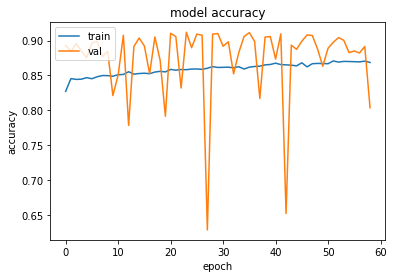

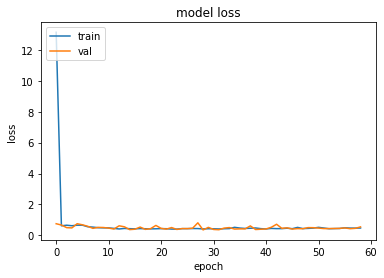

In [ ]:
from keras import regularizers
import seaborn as sns
%matplotlib inline
import seaborn as sns
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization,Conv2D,MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Recall
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.metrics import classification_report,confusion_matrix

input_shape=(image_size,image_size,3)

model=Sequential()


model.add(Conv2D(64,(3,3),input_shape=(image_size,image_size,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())


model.add(Conv2D(512,(3,3),input_shape=(image_size,image_size,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))



model.add(Dropout(0.3))

model.add(Conv2D(1024,(3,3),input_shape=(image_size,image_size,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())


model.add(Dropout(0.4))

model.add(Conv2D(1024,(1,1),input_shape=(image_size,image_size,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(1, 1)))



model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(256,activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))


model.add(Dense(9,activation='softmax'))

model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
    ],
)
model.summary()

history = model.fit(train_generator, 
                     batch_size = batch_size,
                     epochs=num_epochs,
                     use_multiprocessing=True,
                     validation_data = valid_generator,
                     callbacks=callbacks, 
                     #class_weight = weights, 
                     workers=6)

model.save('resnet50_multi_final.h5') 
shutil.copy('resnet50_multi_final.h5', '/content/drive/MyDrive/melanoma_data/models')


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve, auc, average_precision_score, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import PrecisionRecallDisplay



ypred = model.predict(valid_generator)
ypred = ypred.argmax(axis=-1)

precision, recall, _ = precision_recall_curve(valid_generator.labels, ypred)
print('AP:', average_precision_score(valid_generator.labels, ypred, average='macro'))
print('ROC:', roc_auc_score(valid_generator.labels, ypred))
print('AUC:', auc(recall, precision))

AP: 0.09065272050688926
ROC: 0.4951283637488402
AUC: 0.18262683007428054
